In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pathlib
from dotenv import load_dotenv

from ipywidgets import interact, widgets
from plotly.express import imshow as imshow_interactive

In [2]:
from template_match import read_image_rgb, read_image_gray
from hough_transform import calc_gradients, build_hough_model, fill_accumulator, \
    normalize_map, get_first_N_maximums

In [3]:
def draw_image(image: np.ndarray) -> None:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))


def draw_points_on_canvas(points: np.ndarray, image: np.ndarray) -> None:
    x = points[:, 0]
    y = points[:, 1]
    
    clear_canvas = image.copy()
    clear_canvas[:, :] = 255
    plt.scatter(x, y, alpha=0.5, s=5)
    plt.imshow(cv.cvtColor(clear_canvas, cv.COLOR_BGR2RGB))

In [4]:
BASE_DIR = pathlib.Path(__name__).resolve().parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

## Hough detection pipeline (new)

In [15]:
PLOT_NUMBER = 31
MARKER_NUMBER = 3

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"


# PLOT_PATH = DATA_PATH / "generated_plots" / f"plot_{PLOT_NUMBER}.png"
# # TEMPLATE_PATH = DATA_PATH / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / "generated_plots" / "markers" / f"plot_{PLOT_NUMBER}_marker_{MARKER_NUMBER}.png"

In [16]:
template_rgb = read_image_rgb(TEMPLATE_PATH)
source_image = read_image_rgb(PLOT_PATH)

image = np.copy(source_image)

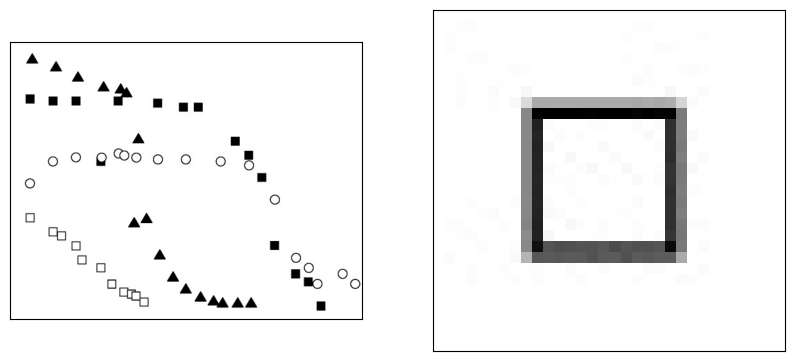

In [17]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
draw_image(source_image)
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(template_rgb)
plt.xticks([]); plt.yticks([])
None

In [18]:
hough_model = build_hough_model(template_rgb)

In [19]:
accumulator = fill_accumulator(hough_model, source_image)

In [20]:
accumulator_normed = normalize_map(accumulator)

In [2]:
imshow_interactive(accumulator_normed)

NameError: name 'imshow_interactive' is not defined

**Example: first N maximums of accumulator**

In [12]:
# example
maximums = get_first_N_maximums(accumulator_normed, 10)
y_points = np.array( [pt[1][0] for pt in maximums] )
x_points = np.array( [pt[1][1] for pt in maximums] )

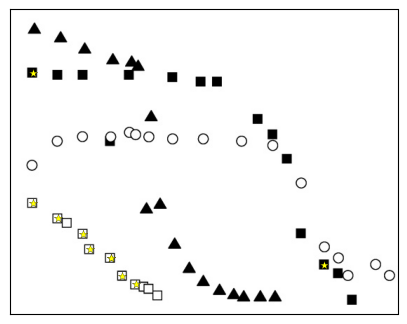

In [13]:
## founded points on original image
plt.figure(figsize=(5, 5))
draw_image(source_image)

plt.scatter(x_points, y_points, s=40, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
plt.xticks([]); plt.yticks([]);

**Interactive: first N maximums**

In [22]:
MAXIMUMS_NUMBER_LIMIT = 100

In [23]:
@interact(N_maximums=widgets.FloatSlider(value=1, min=1, max=MAXIMUMS_NUMBER_LIMIT, step=1))
def visualize(N_maximums):

    ## get max points
    N_maximums = int(N_maximums)
    maximums = get_first_N_maximums(accumulator_normed, N_maximums)
    y_points = np.array( [pt[1][0] for pt in maximums] )
    x_points = np.array( [pt[1][1] for pt in maximums] )

    ## founded points on original image
    plt.figure(figsize=(9, 9))
    draw_image(source_image)

    plt.scatter(x_points, y_points, s=50, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
    plt.xticks([]); plt.yticks([]);
    plt.title(f"{N_maximums=}")
    plt.show()


    # <.. here may be clustering step ..>
    actual_points = np.stack((x_points, y_points)).T
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)


interactive(children=(FloatSlider(value=1.0, description='N_maximums', min=1.0, step=1.0), Output()), _dom_cla…

## Gradients vizualization

In [10]:
PLOT_NUMBER = 31
MARKER_NUMBER = 3

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

In [11]:
template_rgb = read_image_rgb(TEMPLATE_PATH)
source_image = read_image_rgb(PLOT_PATH)

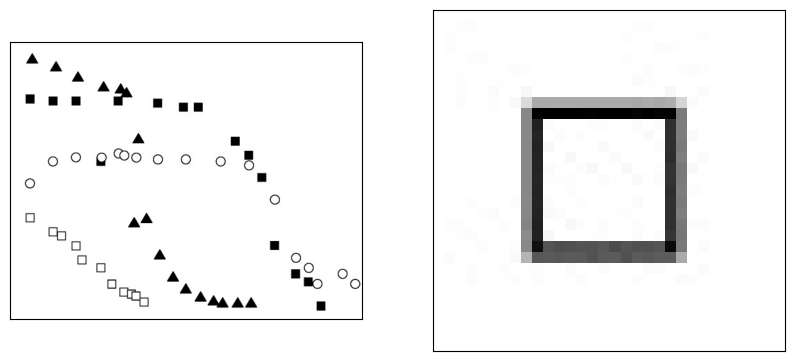

In [12]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
draw_image(source_image)
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(template_rgb)
plt.xticks([]); plt.yticks([])
None

In [13]:
# Good for the b/w test images used
MIN_CANNY_THRESHOLD = 10
MAX_CANNY_THRESHOLD = 50

template_edges = cv.Canny(
    template_rgb,
    threshold1=MIN_CANNY_THRESHOLD, 
    threshold2=MAX_CANNY_THRESHOLD
)
template_gradient = calc_gradients(template_edges)

image_edges = cv.Canny(
    source_image,
    threshold1=MIN_CANNY_THRESHOLD, 
    threshold2=MAX_CANNY_THRESHOLD
)
image_gradient = calc_gradients(image_edges)

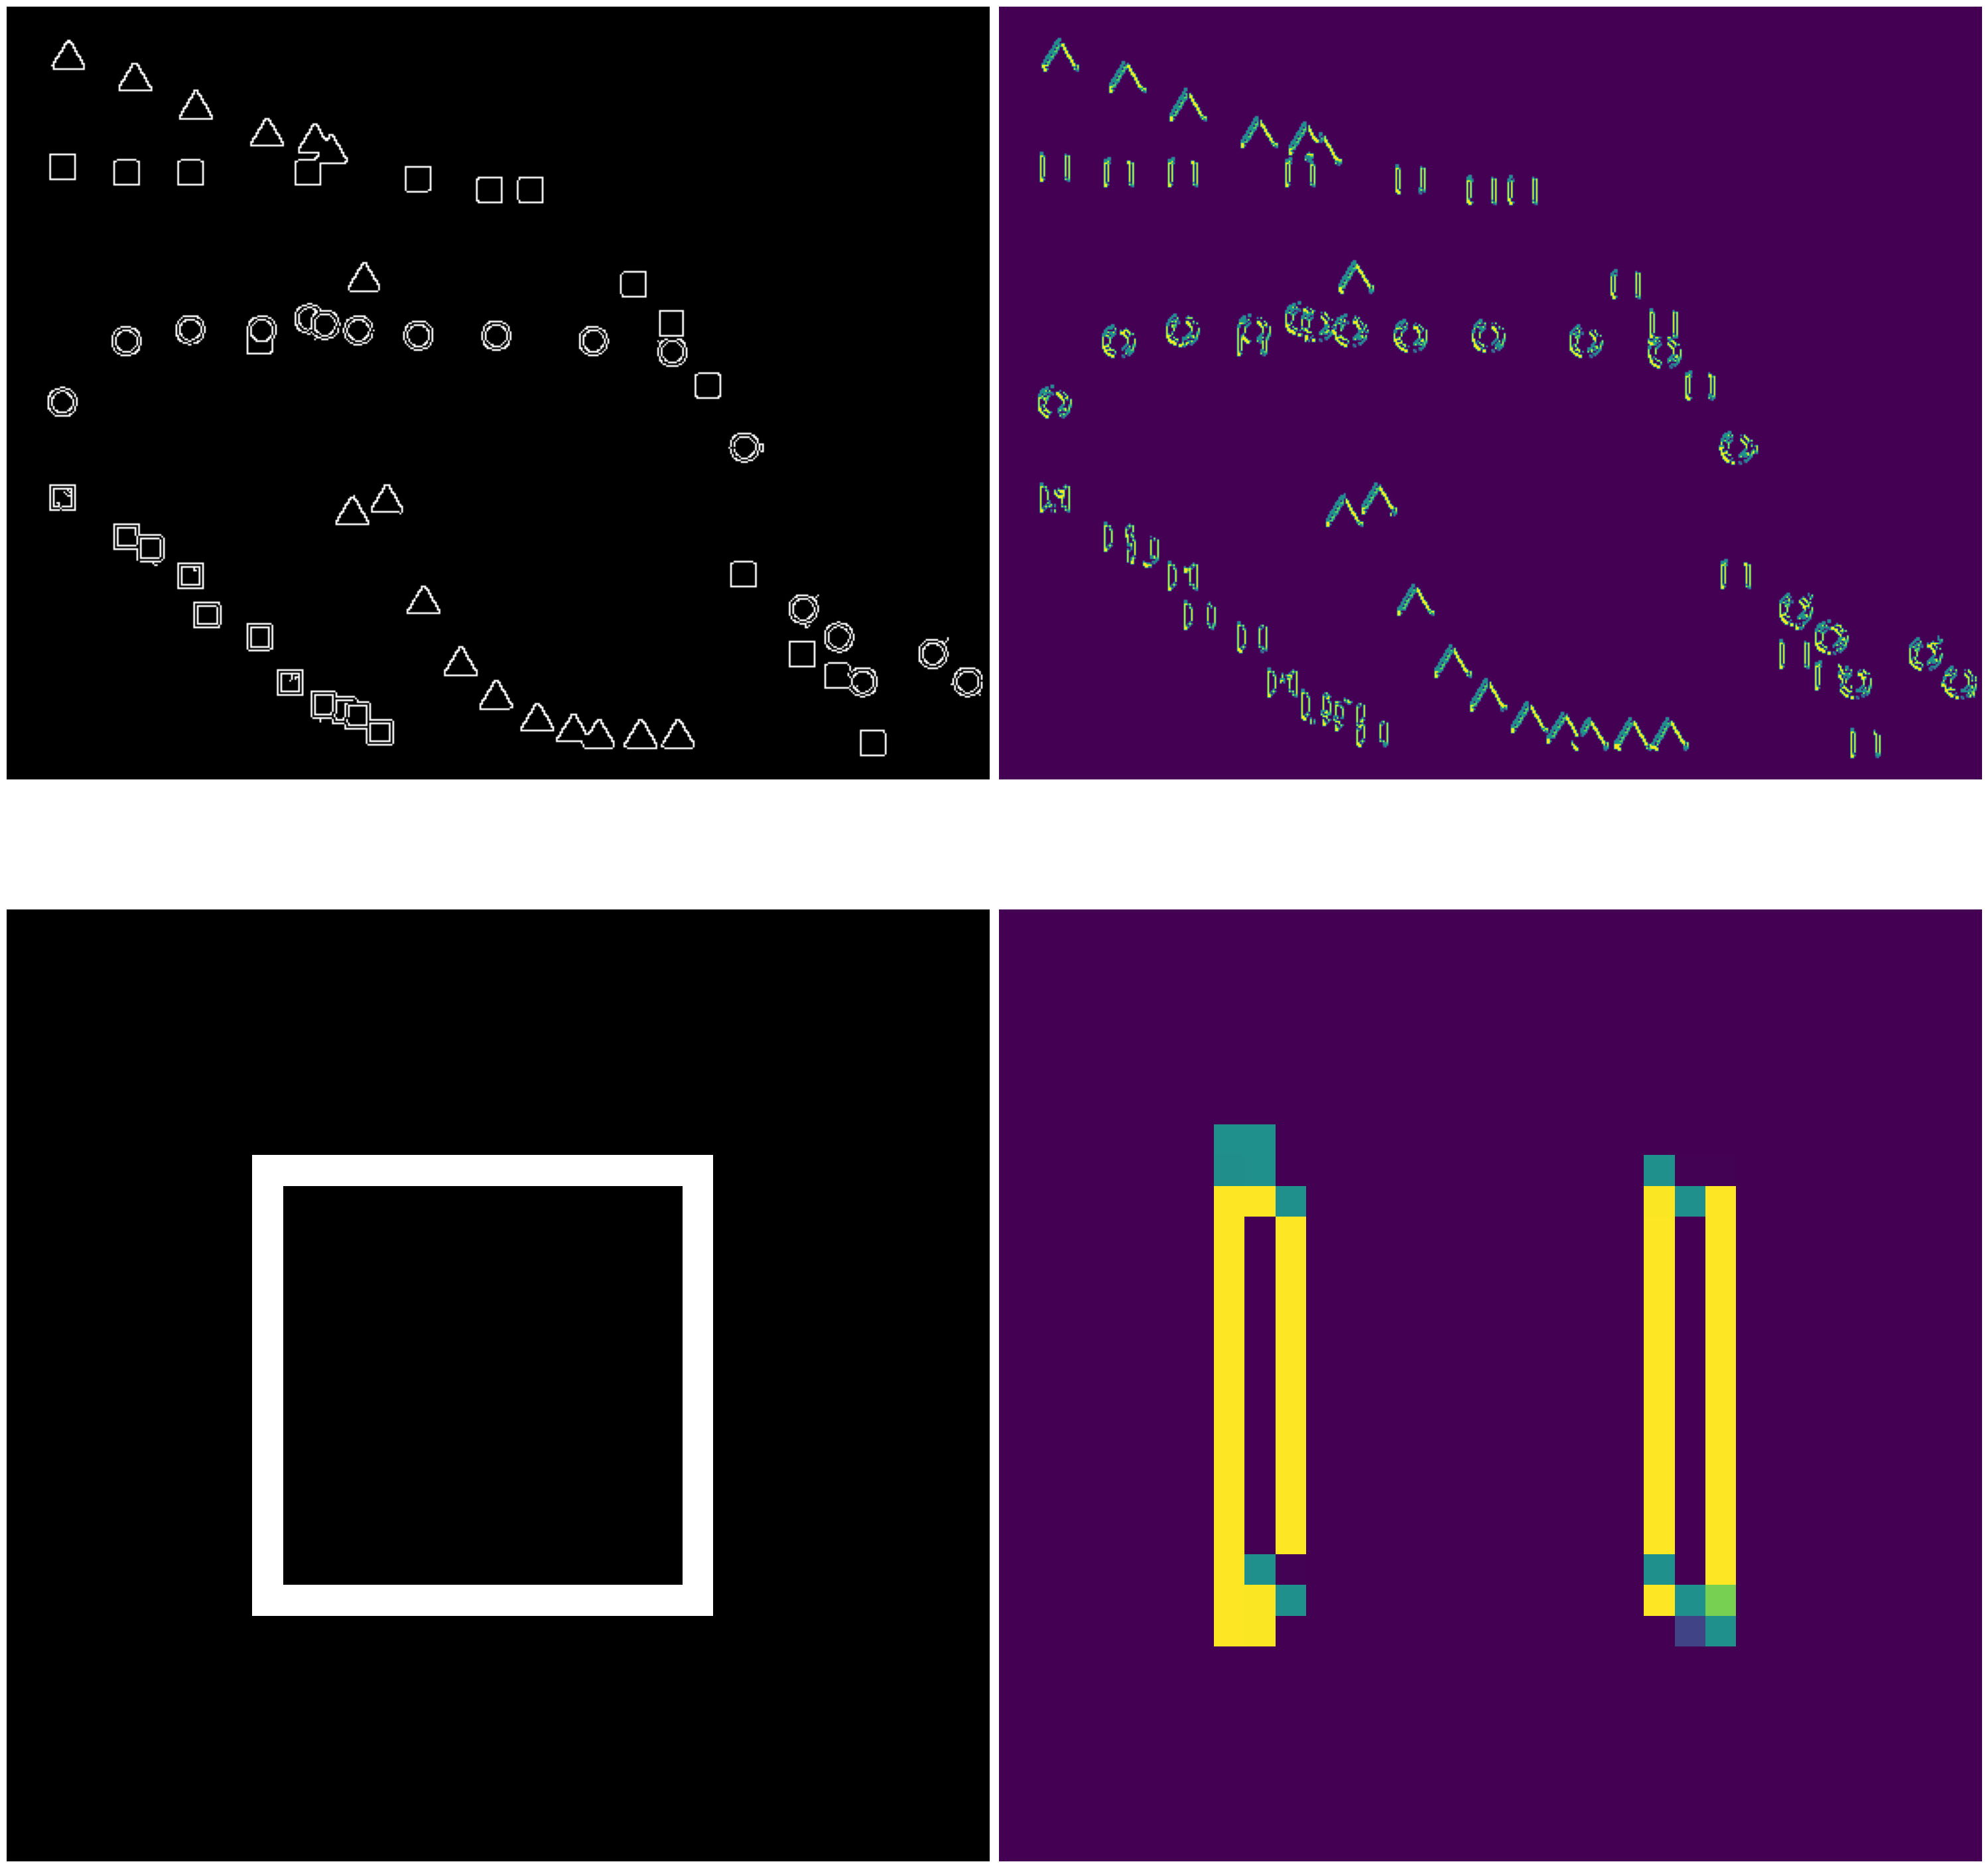

In [9]:
plt.figure(figsize=(60, 60))

plt.subplot(2, 4, 1)
draw_image(image_edges)
plt.axis("off")

plt.subplot(2, 4, 2)
plt.imshow(image_gradient)
plt.axis("off")

plt.subplot(1, 4, 1)
draw_image(template_edges)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(template_gradient)
plt.axis("off")

plt.tight_layout()

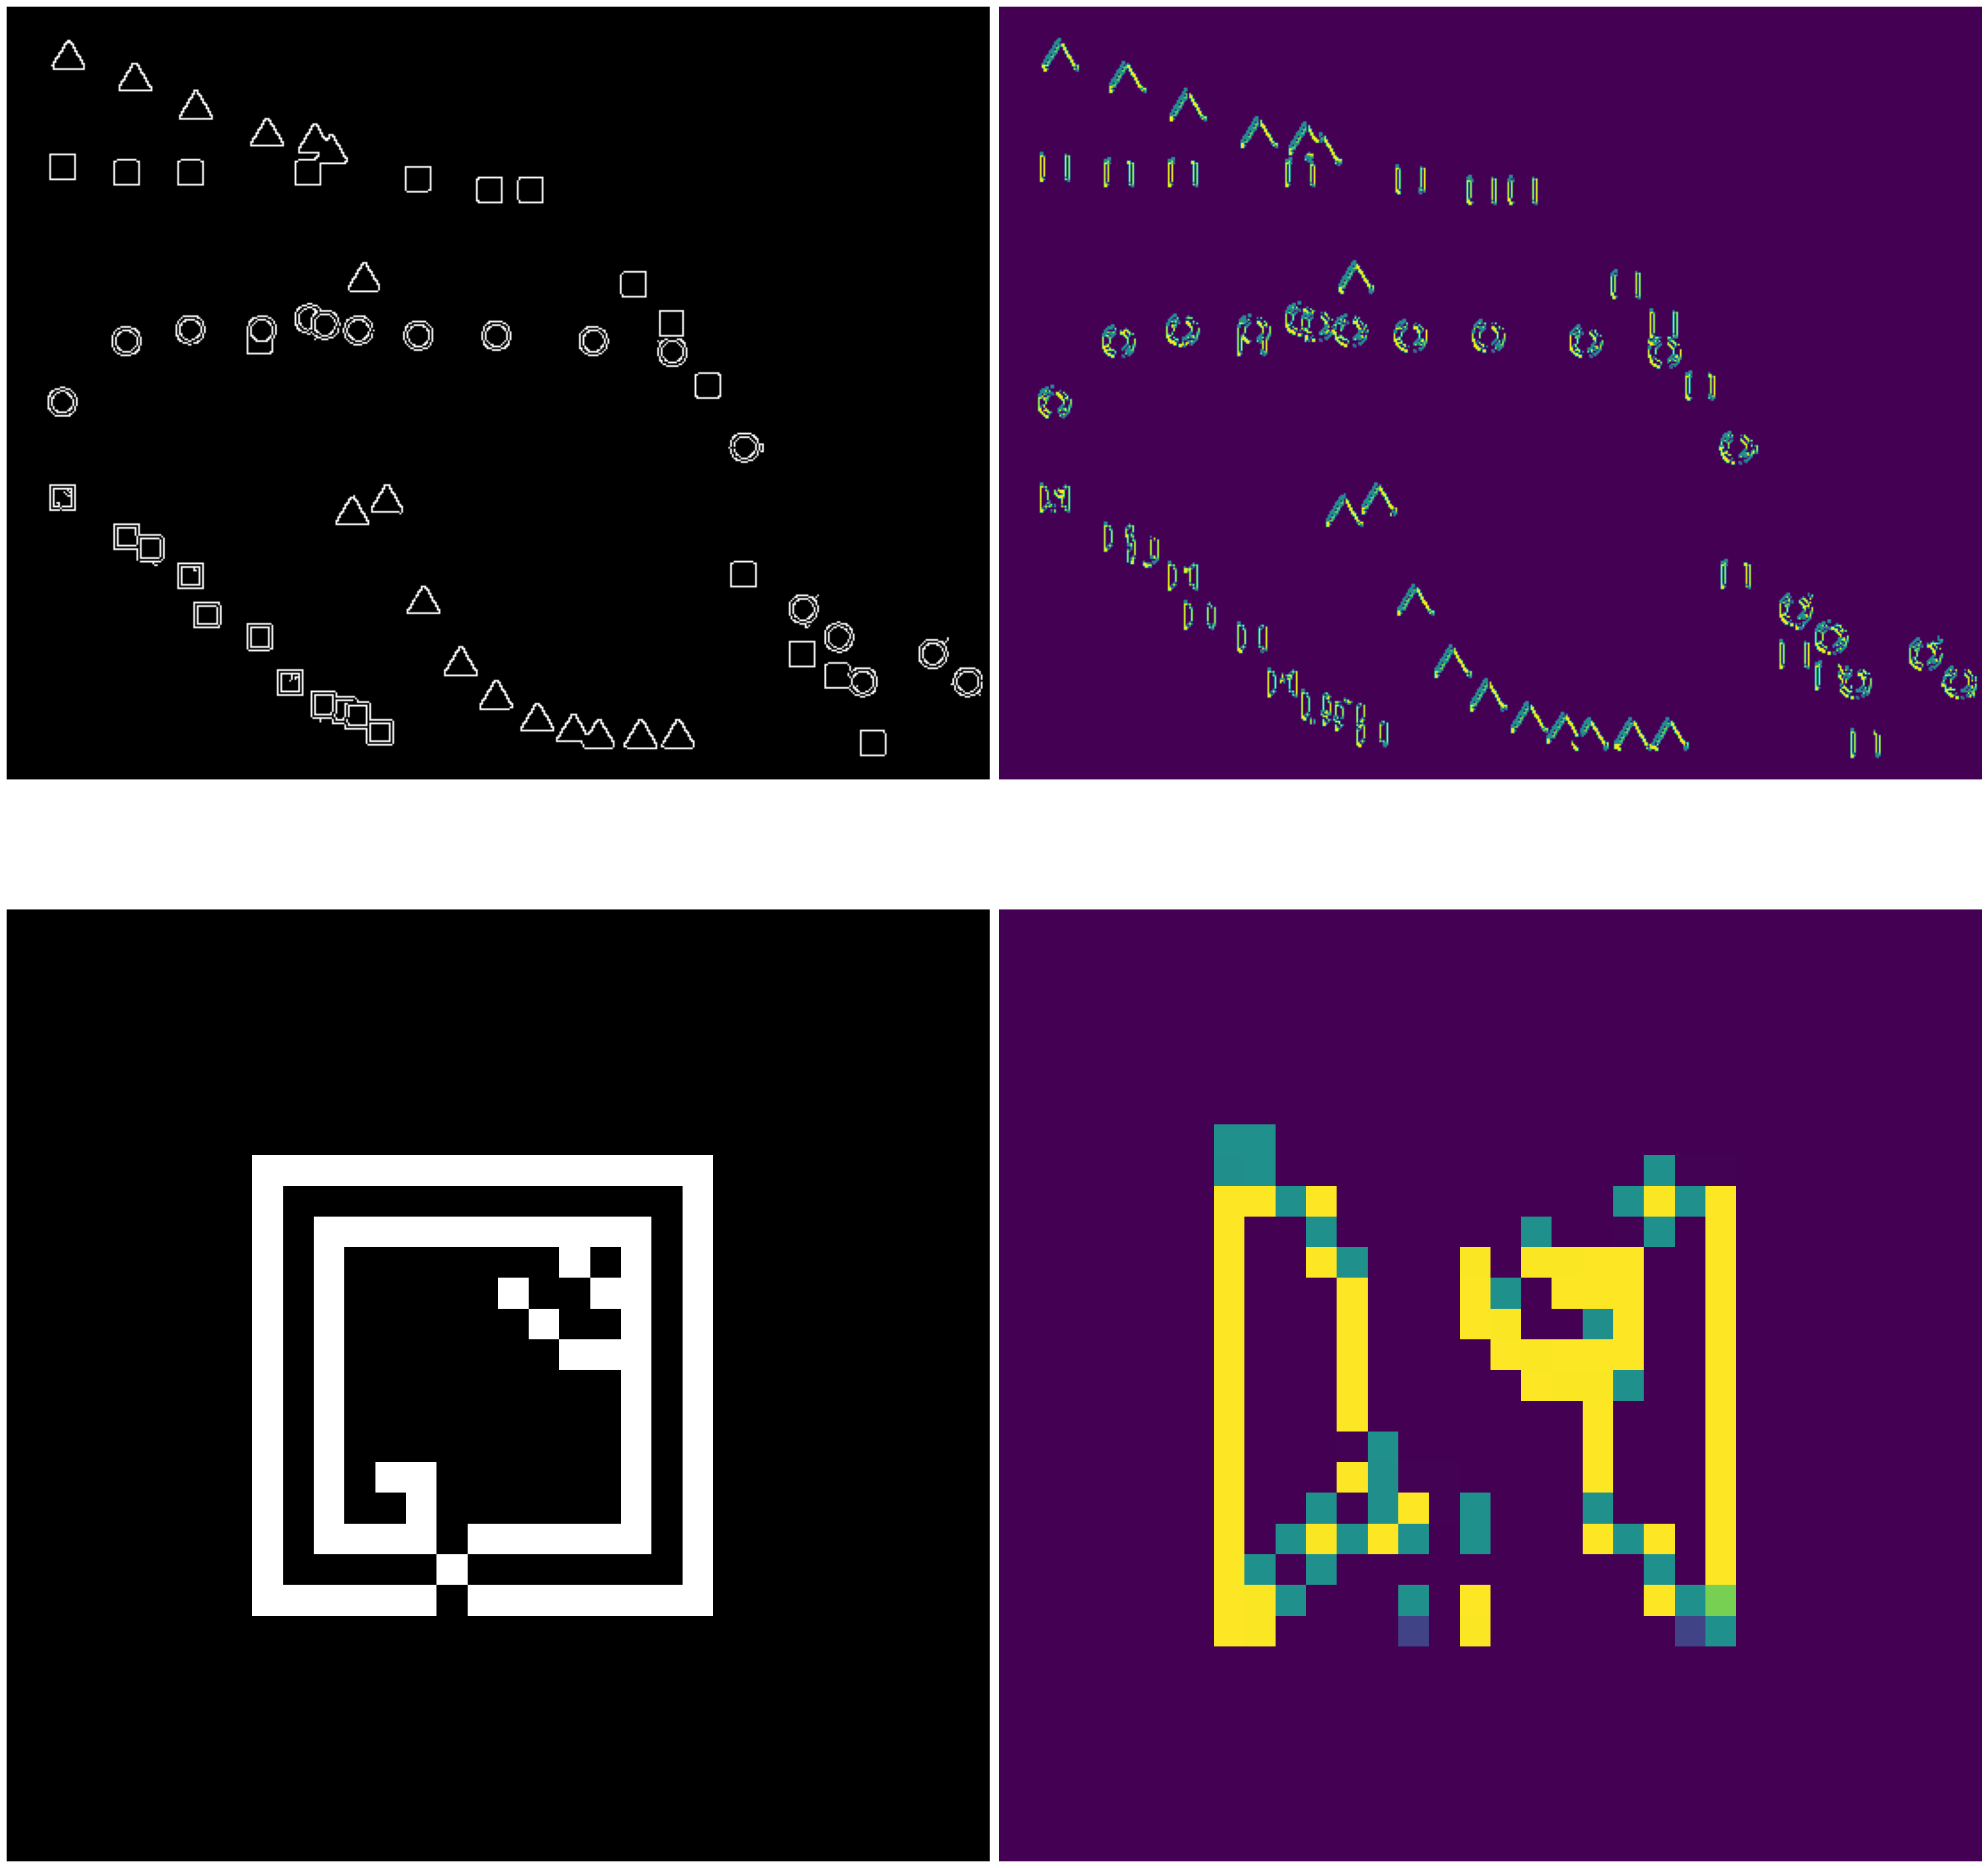

In [14]:
plt.figure(figsize=(60, 60))

plt.subplot(2, 4, 1)
draw_image(image_edges)
plt.axis("off")

plt.subplot(2, 4, 2)
plt.imshow(image_gradient)
plt.axis("off")

plt.subplot(1, 4, 1)
draw_image(template_edges)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(template_gradient)
plt.axis("off")

plt.tight_layout()

## Old experiments with Hough

In [20]:
from collections import defaultdict
import cv2 as cv
# from scipy.ndimage.filters import sobel
from scipy.ndimage import sobel
import pathlib
from dotenv import load_dotenv

from ipywidgets import interact, widgets
from plotly.express import imshow as imshow_interactive

In [21]:
# Good for the b/w test images used
MIN_CANNY_THRESHOLD = 10
MAX_CANNY_THRESHOLD = 50

In [22]:
def gradient_orientation(image):
    """
    Calculate the gradient orientation for edge point in the image
    """
    dx = sobel(image, axis=0, mode='constant')
    dy = sobel(image, axis=1, mode='constant')
    gradient = np.arctan2(dy,dx) * 180 / np.pi
    
    return gradient

In [23]:
def build_r_table(image, origin):
    """
    Build the R-table from the given shape image and a reference point

    :param image: template image
    :param origin: reference point
    """
    edges = cv.Canny(image, threshold1=MIN_CANNY_THRESHOLD,
                  threshold2=MAX_CANNY_THRESHOLD)
    gradient = gradient_orientation(edges)
    
    r_table = defaultdict(list)
    for (i,j),value in np.ndenumerate(edges):
        if value:
            r_table[gradient[i,j]].append((origin[0]-i, origin[1]-j))

    return r_table

In [24]:
def accumulate_gradients(r_table, grayImage):
    """
    Perform a General Hough Transform with the given image and R-table

    :param grayImage: image where we try to find template (polt image)
    """
    edges = cv.Canny(grayImage, threshold1=MIN_CANNY_THRESHOLD,
                  threshold2=MAX_CANNY_THRESHOLD)
    gradient = gradient_orientation(edges)
    
    accumulator = np.zeros(grayImage.shape)
    for (i,j),value in np.ndenumerate(edges):
        if value:
            for r in r_table[gradient[i,j]]:
                accum_i, accum_j = i+r[0], j+r[1]
                if accum_i < accumulator.shape[0] and accum_j < accumulator.shape[1]:
                    accumulator[accum_i, accum_j] += 1
                    
    return accumulator

In [25]:
# def general_hough_closure(reference_image):
#     '''
#     Generator function to create a closure with the reference image and origin
#     at the center of the reference image
    
#     Returns a function f, which takes a query image and returns the accumulator
#     '''
#     referencePoint = (reference_image.shape[0]//2, reference_image.shape[1]//2)
#     r_table = build_r_table(reference_image, referencePoint)
    
#     def f(query_image):
#         return accumulate_gradients(r_table, query_image)
        
#     return f

In [26]:
def n_max(a, n):
    """
    Return the N max elements and indices in a
    """
    indices = a.ravel().argsort()[-n:]
    indices = (np.unravel_index(i, a.shape) for i in indices)
    return [(a[i], i) for i in indices]

In [27]:
PLOT_NUMBER = 10
MARKER_NUMBER = 2

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_orig" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"


# PLOT_PATH = DATA_PATH / "generated_plots" / f"plot_{PLOT_NUMBER}.png"
# # TEMPLATE_PATH = DATA_PATH / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / "generated_plots" / "markers" / f"plot_{PLOT_NUMBER}_marker_{MARKER_NUMBER}.png"

In [28]:
# PLOT_PATH = DATA_PATH / "petals_image.png"
# TEMPLATE_PATH = DATA_PATH / "petals_template.png"

In [29]:
template = read_image_gray(TEMPLATE_PATH)
image = read_image_gray(PLOT_PATH)

source_image = read_image_rgb(PLOT_PATH)

([], [])

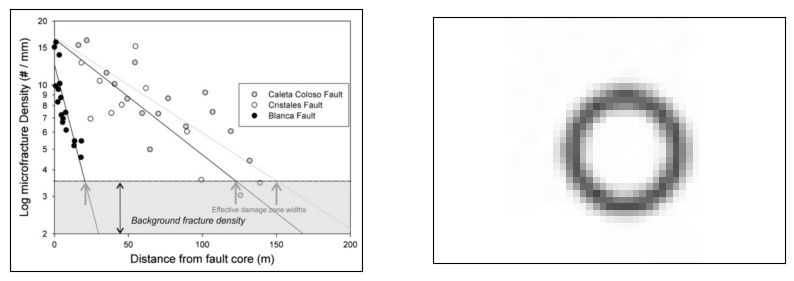

In [30]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
draw_image(image)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(template)
plt.xticks([])
plt.yticks([])

In [31]:
MIN_CANNY_THRESHOLD = 10
MAX_CANNY_THRESHOLD = 50
# MIN_CANNY_THRESHOLD = 240
# MAX_CANNY_THRESHOLD = 700


template_edges = cv.Canny(
    template,
    threshold1=MIN_CANNY_THRESHOLD, 
    threshold2=MAX_CANNY_THRESHOLD
)
template_gradient = gradient_orientation(template_edges)

image_edges = cv.Canny(
    image,
    threshold1=MIN_CANNY_THRESHOLD, 
    threshold2=MAX_CANNY_THRESHOLD
)
image_gradient = gradient_orientation(image_edges)

(-0.5, 52.5, 36.5, -0.5)

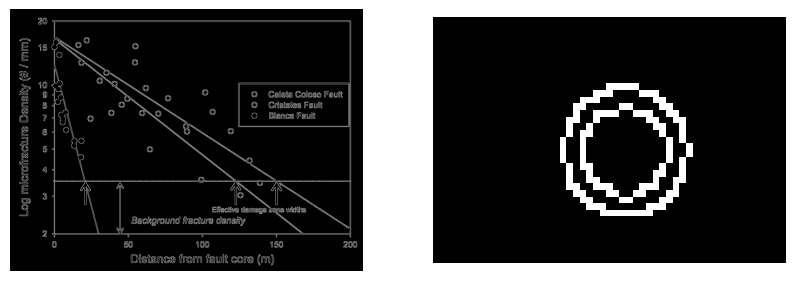

In [32]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
draw_image(image_edges)
plt.axis("off")

plt.subplot(1, 2, 2)
draw_image(template_edges)
plt.axis("off")

(-0.5, 52.5, 36.5, -0.5)

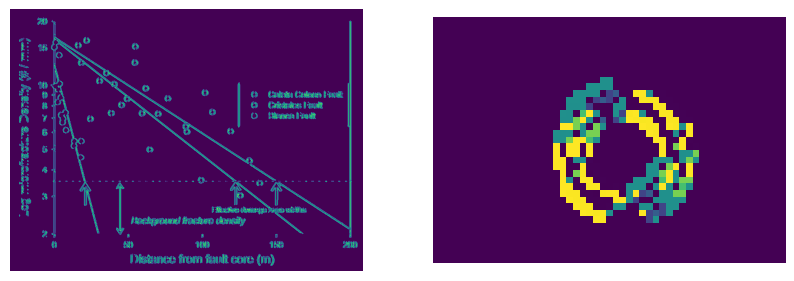

In [33]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_gradient)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(template_gradient)
plt.axis("off")

In [34]:
dx = sobel(template_edges, axis=0, mode='constant')
dy = sobel(template_edges, axis=1, mode='constant')
gradient = np.arctan2(dy,dx) * 180 / np.pi

In [18]:
# imshow_interactive(gradient)

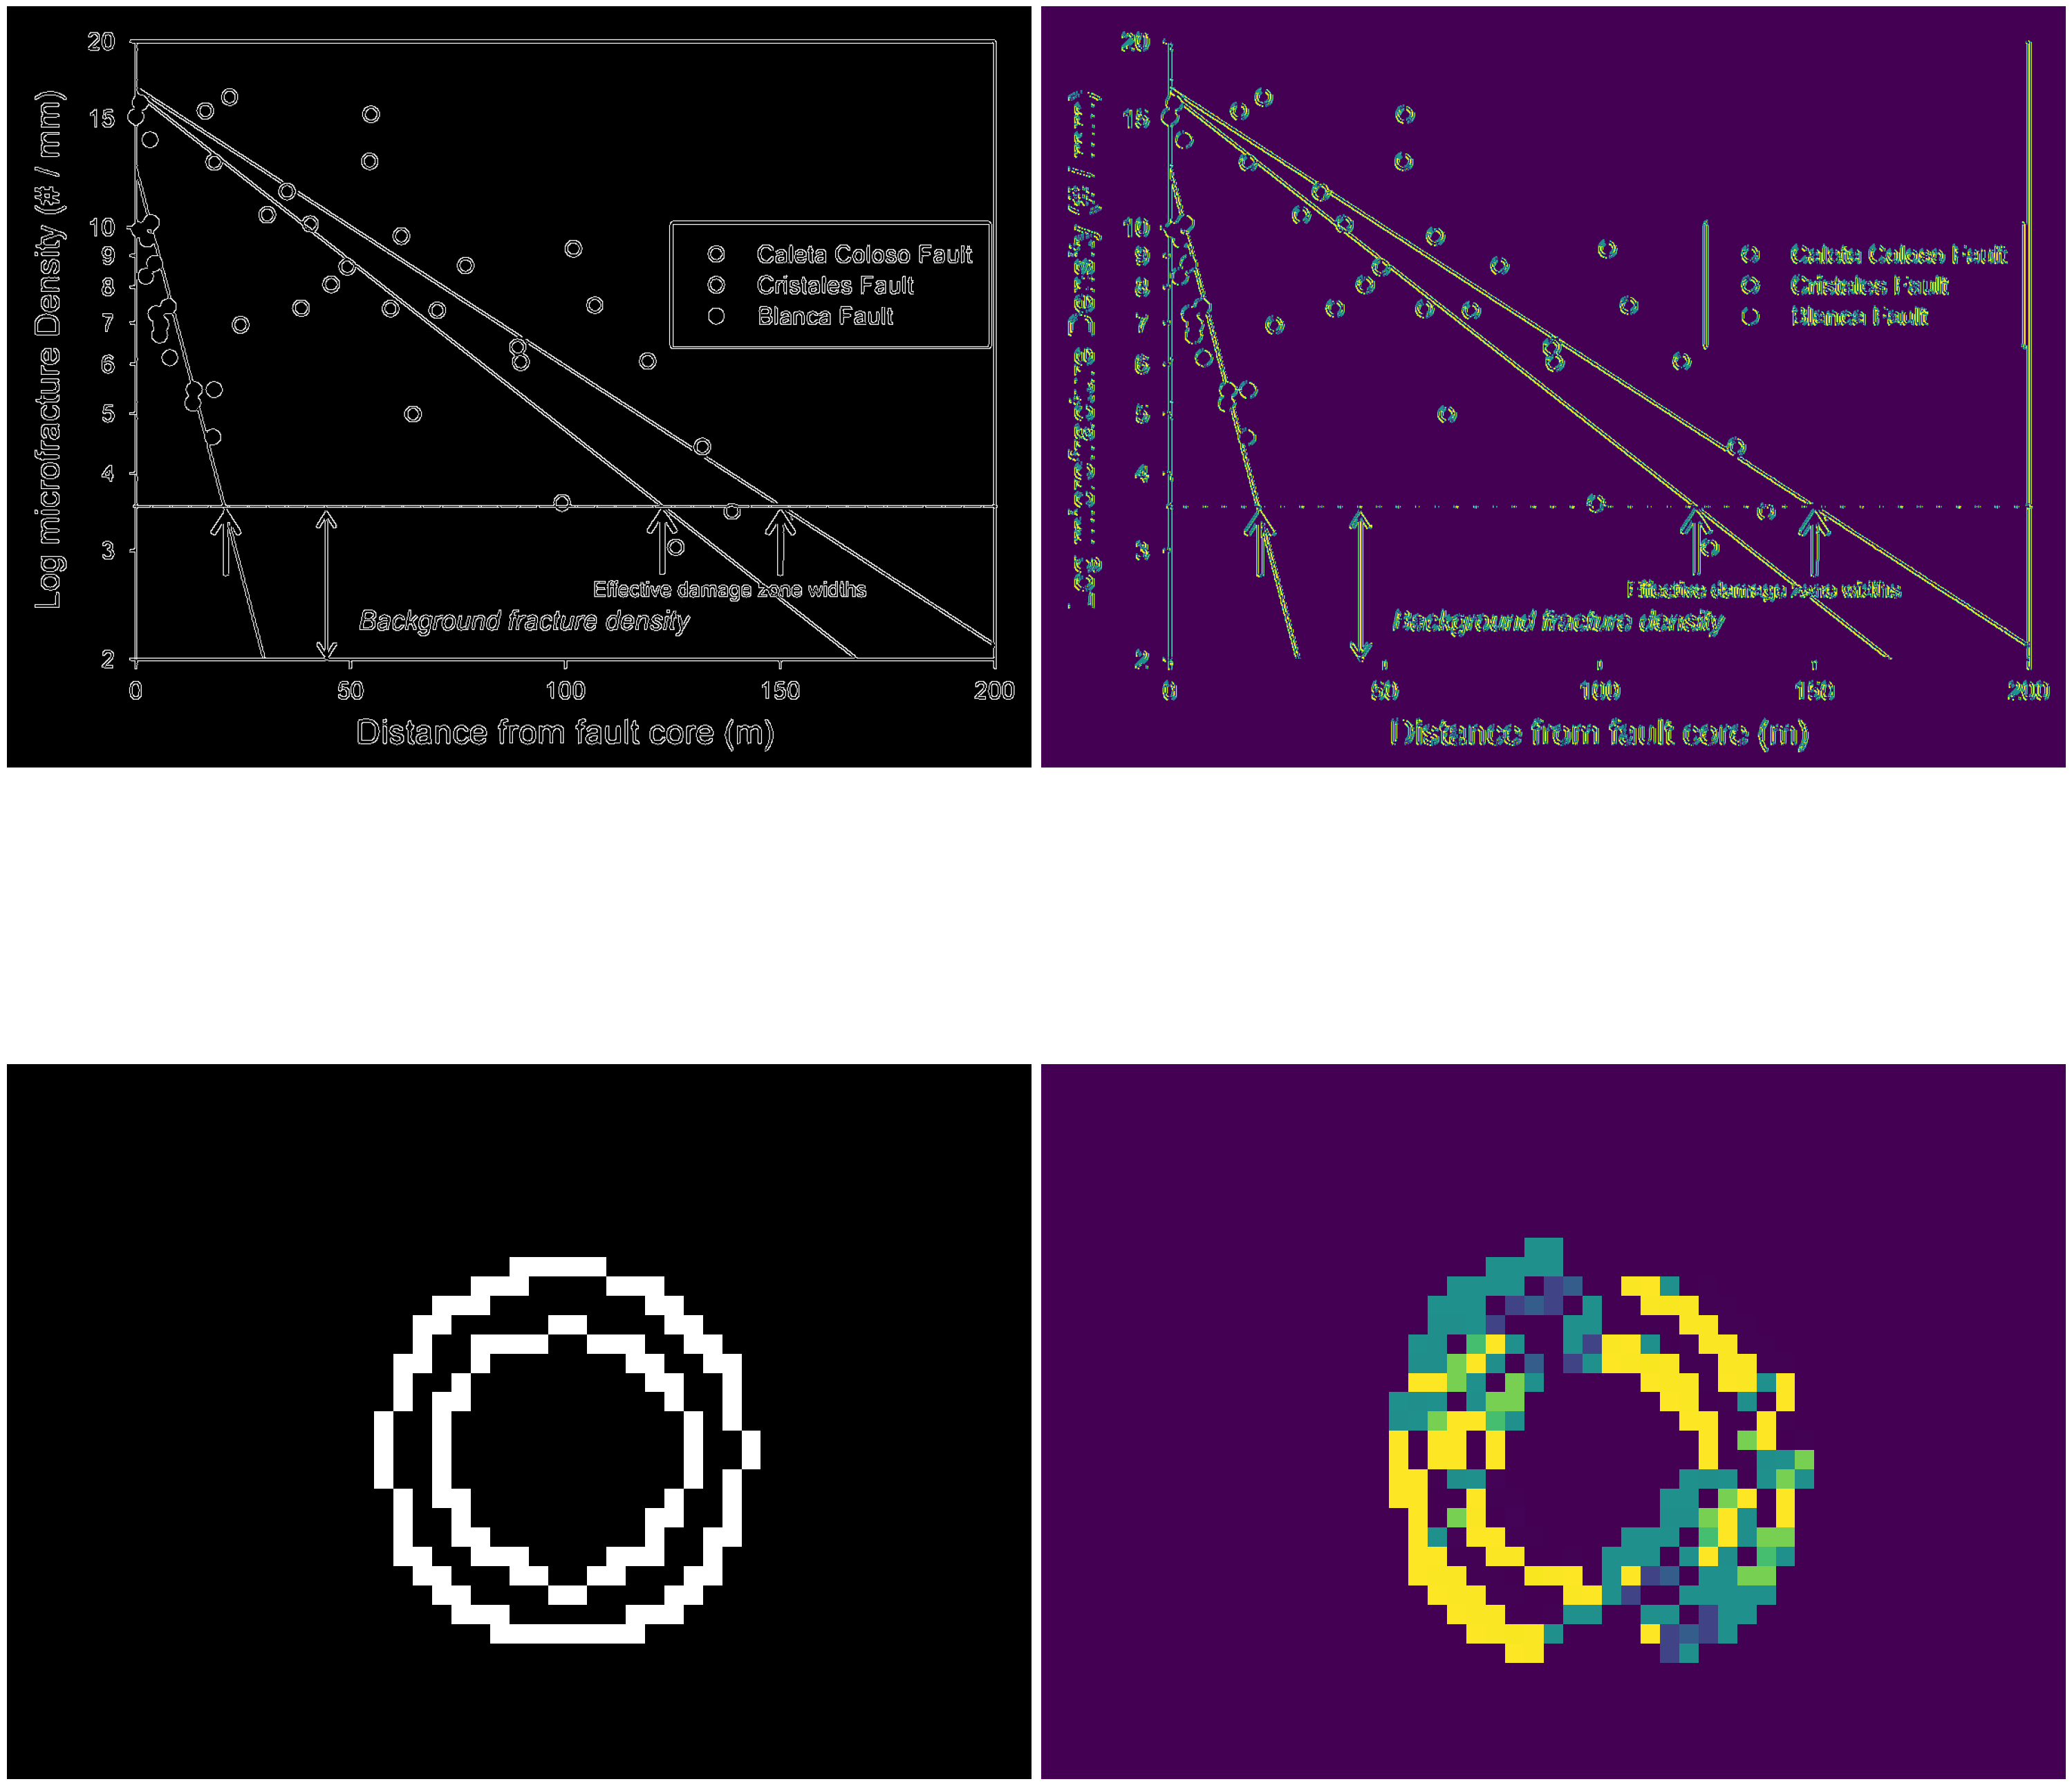

In [36]:
plt.figure(figsize=(60, 60))

plt.subplot(2, 4, 1)
draw_image(image_edges)
plt.axis("off")

plt.subplot(2, 4, 2)
plt.imshow(image_gradient)
plt.axis("off")

plt.subplot(1, 4, 1)
draw_image(template_edges)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(template_gradient)
plt.axis("off")

plt.tight_layout()

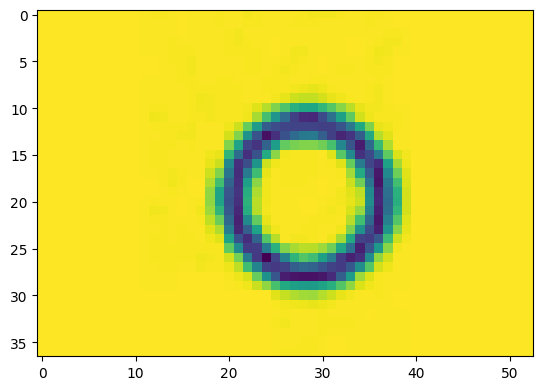

In [37]:
plt.imshow(template)

In [38]:
referencePoint = (template.shape[0]//2, template.shape[1]//2)
r_table = build_r_table(template, referencePoint)

In [39]:
accumulator = accumulate_gradients(r_table, image)

In [19]:
# imshow_interactive(accumulator, width=800, height=700)

In [42]:
@interact(tolerance=widgets.FloatSlider(value=1, min=1, max=100, step=1))
def visualize(tolerance):

    m = n_max(accumulator, int(tolerance))
    y_points = [pt[1][0] for pt in m]
    x_points = [pt[1][1] for pt in m]
    # plt.scatter(x_points, y_points, marker='o', color='r')


    ## founded points on original image
    plt.figure(figsize=(9, 9))
    draw_image(source_image)

    plt.scatter(x_points, y_points, s=50, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
    plt.xticks([]); plt.yticks([]);
    plt.title(f"tolerance = {tolerance}")
    plt.show()

    actual_points = np.stack((x_points, y_points)).T
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)


interactive(children=(FloatSlider(value=1.0, description='tolerance', min=1.0, step=1.0), Output()), _dom_clas…

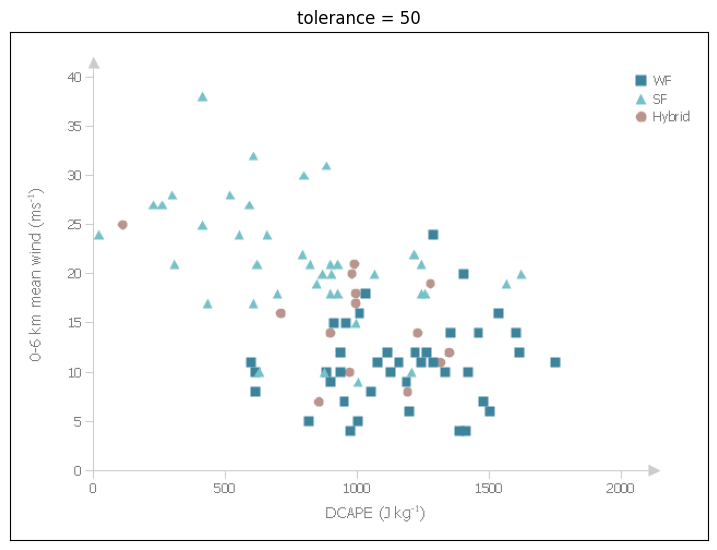

In [48]:
tolerance = 50
m = n_max(accumulator, tolerance)
y_points = np.array( [pt[1][0] for pt in m] )
x_points = np.array( [pt[1][1] for pt in m] )
# plt.scatter(x_points, y_points, marker='o', color='r')


## founded points on original image
plt.figure(figsize=(9, 9))
draw_image(source_image)

# plt.scatter(x_points-1, y_points, s=80, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
plt.xticks([]); plt.yticks([]);
plt.title(f"tolerance = {tolerance}")
plt.show()